# Table of Contents

1. [Medical Disclaimer](#disclaimer)
2. [Preamble and loading the data](#loaddata)
3. [Describe the basics of your glucose data through boxplots](#gludat)
4. [The carbohydrate test](#carb)
5. [The coefficient of variation (CV)](#cv)
6. [Exercise influence](#exercise)
7. [Conclusion](#conclusion)

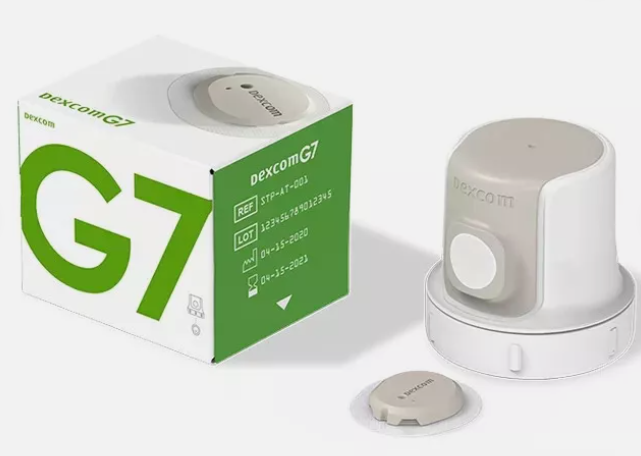

# 1. Medical Advice Disclaimer <a class="anchor"  id="disclaimer"></a>
This code/analysis does not contain medical advice. The information, including but not limited to text, graphics, images, and other material contained in this program are for informational purposes only. No material in this program is intended to be a substitute for professional medical advice, diagnosis or treatment. Always seek the advice of your physician or qualified health care provider with any questions you may have regarding a medical condition or treatment and before undertaking a new health care regimen, and never disregard professional medical advice or delay in seeking it because of something you have read or learned here.


# 2. Preamble and loading the data <a class="anchor"  id="loaddata"></a>

I wore a Dexcom G7 sensor for the period 31 Jan 2025 to 10 Feb 2025. I am not diagnosed as diabetic or even pre-diabetic or anything similar, I merely wanted to understand my body's glucose response to various foods and exercise. 

The data exported from the sensor can be found in the file beginning with Clarity_Export_. The sensor itself only works for 10 days with a grace period of 12 hrs, which is why you will see data for 11 days, from around 10 am on friday the 31st Jan 2025 to 8pm on 10th Feb 2025. What I sought to do during the 10 days was understand the impact on my glucose levels different foods had. I also deliberately ate carbs as per normal for the first period 5 days, and then roughly halved my carb intake for the 2nd period of 5 days. So we basically have an AB test the effects of which we can look for in the data. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime
from matplotlib.dates import date2num

%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dexcom-sensor-data/Clarity_Export_2025-02-11_032331.csv
/kaggle/input/nutrient-density-satiety-and-glucose-data/sugar_data.csv
/kaggle/input/nutrient-density-satiety-and-glucose-data/foods_data.csv
/kaggle/input/nutrient-density-satiety-and-glucose-data/Clarity_Export_2025-02-10_065231.csv
/kaggle/input/nutrient-density-satiety-and-glucose-data/food_glucose_data.csv
/kaggle/input/nutrient-density-satiety-and-glucose-data/net carbs vs glucose score vs satiety index_data_.csv


#### Load the Dexcom data

Note you need to remove the first 12 lines of non data...

In [2]:
import warnings
warnings.filterwarnings("ignore")

# SELECT YOUR OWN CSV FILE BELOW:
df = pd.read_csv('/kaggle/input/dexcom-sensor-data/Clarity_Export_2025-02-11_032331.csv', index_col = 0)

glucose = df[['Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mmol/L)']]
glucose = glucose.drop([1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12])

glucose.reset_index(drop=True, inplace=True)
glucose['Timestamp (YYYY-MM-DDThh:mm:ss)'] = pd.to_datetime(glucose['Timestamp (YYYY-MM-DDThh:mm:ss)'])

glucose = glucose.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)' : 'Timestamp'})
glucose['Glucose Value (mmol/L)'] = glucose['Glucose Value (mmol/L)'].astype(float)
glucose = glucose.dropna()
glucose.head()

,Timestamp,Glucose Value (mmol/L)
0,2025-01-31 10:38:43,5.4
1,2025-01-31 10:43:43,5.6
2,2025-01-31 10:48:43,5.7
3,2025-01-31 10:53:42,5.9
4,2025-01-31 10:58:43,5.9


# 3. describe the basics of your glucose data in one boxplot <a class="anchor"  id="gludat"></a>

<Figure size 1000x400 with 0 Axes>

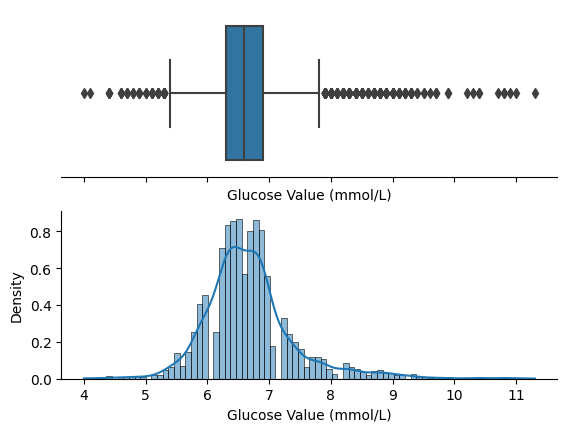

In [3]:
plt.figure(figsize=(10,4))


f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.5, .5)})

sns.boxplot(x=glucose['Glucose Value (mmol/L)'], ax=ax_box)
sns.histplot(x=glucose['Glucose Value (mmol/L)'], bins=80, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)


From the above we can see the average glucose sat somehwere between 6 and 7 mmol/L for the most part. Let's break that down by day:

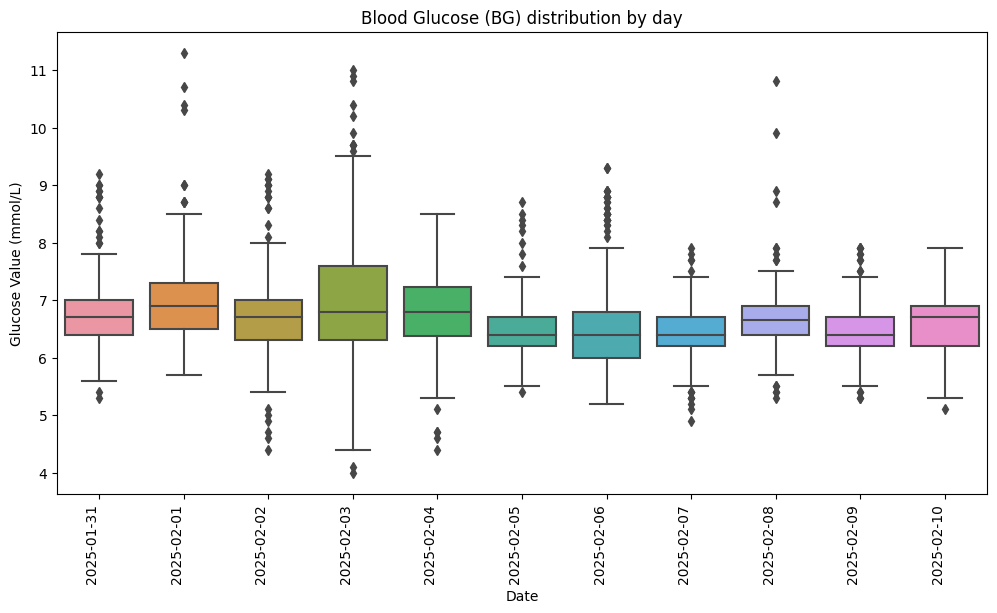

In [4]:
plt.figure(figsize=(12,6))
glucose['Day'] = glucose['Timestamp'].dt.day_name()
glucose['Date'] = glucose['Timestamp'].dt.date
sns.boxplot(x= glucose['Date'],y=glucose['Glucose Value (mmol/L)'])
plt.title('Blood Glucose (BG) distribution by day')
plt.xticks(rotation=90, ha='right');

# 4. The carbohydrate test <a class="anchor"  id="carb"></a>

OK lets compare the first 5 days to the second 5 days, by creating a variable and then plotting. Remember, for the first 5 days I ate carbs normally (denoted by 'Normal' category in graph), and even tested a sweets and coke combo on one day, while during the 2nd 5 days I halved my daily carb intake from around 200 grams/day to 100 grams/day (denoted by 'Lower' category in below graphs).

Let's import my carb intake data and visualize the carb intake by period.

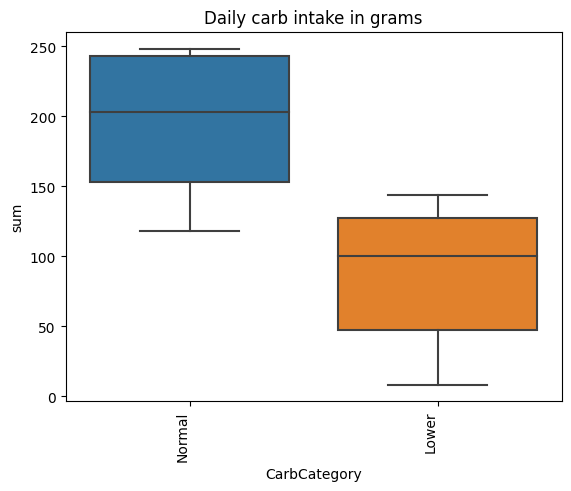

In [5]:
diet = pd.read_csv('/kaggle/input/nutrient-density-satiety-and-glucose-data/food_glucose_data.csv')
agg_diet = diet.groupby(['date'])['carbs'].agg(['sum']).reset_index()

agg_diet['date'] = pd.Categorical(agg_diet['date'], ['31/01/2025','01/02/2025','02/02/2025','03/02/2025','04/02/2025','05/02/2025','06/02/2025','07/02/2025','08/02/2025','09/02/2025'])
agg_diet = agg_diet.sort_values(by='date')

agg_diet['date'] = agg_diet['date'].astype(str)
agg_diet['CarbCategory'] = np.where(agg_diet['date'] <= '04/02/2025','Normal','Lower')
sns.boxplot(x=agg_diet['CarbCategory'].sort_values(ascending=False),y=agg_diet['sum'])
plt.title('Daily carb intake in grams');
plt.xticks(rotation=90, ha='right');


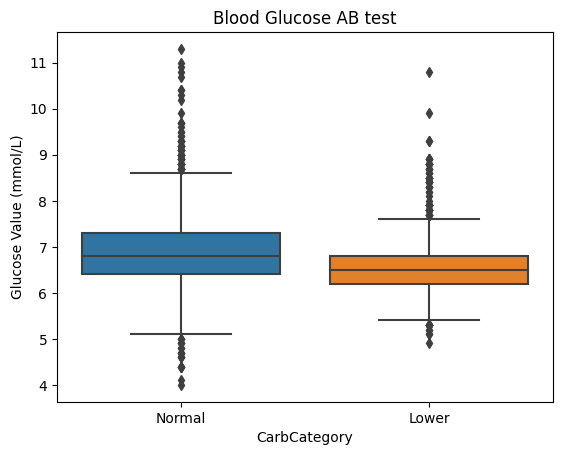

In [6]:
glucose['Date'] = glucose['Date'].astype(str)
glucose['CarbCategory'] = np.where(glucose['Date'] <= '2025-02-04','Normal','Lower')
sns.boxplot(x=glucose['CarbCategory'],y=glucose['Glucose Value (mmol/L)'])
plt.title('Blood Glucose AB test');

From the above you can see that the 2nd period of 'Lower' carbohydrate intake corresponds with a tighter range of blood glucose (BG) readings and also a lower IQR and median. Another dimension that can be analysed is the coefficient of variation. Since the above effect looks small let's run a t-test to see if the two sample means differ significantly:

#### Simple T-Test

In [7]:
from scipy import stats

group1 = glucose[glucose['CarbCategory'] == 'Normal']['Glucose Value (mmol/L)'].astype(float)
group2 = glucose[glucose['CarbCategory'] == 'Lower']['Glucose Value (mmol/L)'].astype(float)[:len(group1)]

t_stat, p_value = stats.ttest_ind(group2, group1,equal_var=False)

print(f"Carb test t-statistic: {t_stat:.4f}")
print(f"Carb test p-value: {p_value:.4f}")

Carb test t-statistic: -12.8811
Carb test p-value: 0.0000


Here’s what these numbers mean:
- The negative t-statistic tells us eating less carbs corresponds with lower BG readings (note order in test)
- The tiny p-value (< 0.01) means this difference is statistically significant
- We can say with 99% confidence that carbs affect BG levels, no surprises here!

# 5. The coefficient of variation (CV) <a class="anchor"  id="carb"></a>

The "coefficient of variation" on blood glucose (BG) levels, often abbreviated as "CV", is a metric used to assess the degree of variability in blood sugar levels over a period of time, essentially showing how much a person's blood sugar fluctuates relative to their average blood sugar level, and is calculated by dividing the standard deviation of glucose readings by the mean glucose level, expressed as a percentage.
A higher CV indicates greater blood sugar variability, meaning larger swings between high and low glucose levels. 

Key points about the coefficient of variation (CV) in blood glucose levels:

* What it measures: The extent of fluctuations in blood sugar levels, regardless of the absolute average glucose value. 
* How it's calculated: (Standard deviation of glucose readings) / (mean glucose level) x 100%. 
* Interpretation:

Low CV: Indicates relatively stable blood sugar levels with minimal fluctuations. 

High CV: Represents significant variations in blood sugar levels, potentially increasing the risk of complications like hypoglycemia. 


In [8]:
def std(x): 
    return np.std(x)

df_cv = glucose.groupby('Date')['Glucose Value (mmol/L)'].agg(['mean', 'max', std]).reset_index()
df_cv['glucose_cv'] = df_cv['std']/df_cv['mean']
df_cv.head(10)

,Date,mean,max,std,glucose_cv
0,2025-01-31,6.808696,9.2,0.732510,0.107584
1,2025-02-01,7.001736,11.3,0.791511,0.113045
2,2025-02-02,6.732292,9.2,0.728082,0.108148
3,2025-02-03,7.027431,11.0,1.181473,0.168123
4,2025-02-04,6.827431,8.5,0.716360,0.104924
5,2025-02-05,6.446875,8.7,0.509756,0.079070
6,2025-02-06,6.562153,9.3,0.860954,0.131200
7,2025-02-07,6.425000,7.9,0.456740,0.071088
8,2025-02-08,6.677431,10.8,0.531779,0.079638
9,2025-02-09,6.459722,7.9,0.466565,0.072227


Text(0.5, 1.0, 'BG CV by carbohydrate intake category')

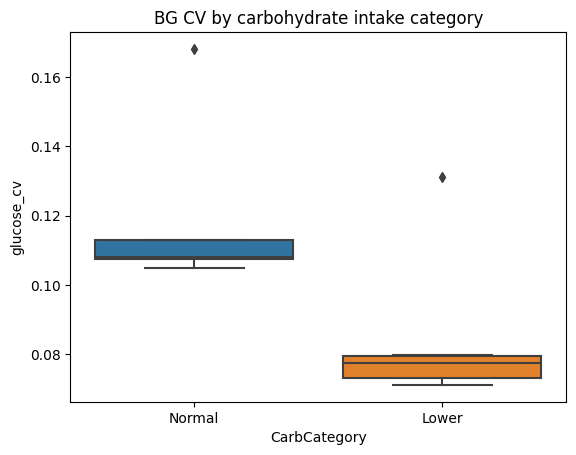

In [9]:
df_cv['CarbCategory'] = np.where(df_cv['Date'] <= '2025-02-04','Normal','Lower')

sns.boxplot(x=df_cv['CarbCategory'],y=df_cv['glucose_cv'])
plt.title('BG CV by carbohydrate intake category')

As a table of values:

In [10]:
df_cv1 = glucose.groupby('CarbCategory')['Glucose Value (mmol/L)'].agg(['mean', 'max', std]).reset_index()
df_cv1['glucose_cv'] = df_cv1['std']/df_cv1['mean']
(df_cv1.sort_values(by='CarbCategory', ascending=False)).style.highlight_min(color='lightgreen')

,CarbCategory,mean,max,std,glucose_cv
1,Normal,6.886367,11.300000,0.867307,0.125945
0,Lower,6.526509,10.800000,0.580437,0.088935


From the above you can see how reducing carbs by half decreases variability appreciably.

# 6. Exercise influence on BG readings <a class="anchor"  id="exercise"></a>

During the sensor period, two saturdays were spanned, which meant that I could understand what impact the runs would have on my BG levels if any. I run the standard 9am 5km park run most saturdays, which I started doing a year ago odd.

In [11]:
glucose['datetime'] = pd.to_datetime(glucose['Timestamp'], format='%Y-%m-%d %H:%M:%S')
glucose['hour'] = glucose['datetime'].dt.hour
glucose['min'] = glucose['datetime'].dt.minute

Lets carve out the two saturday periods between 7 am and noon. During this period, i typically wake up and have a coffee, then do the run, then go shopping before I finally head home and eat for the first time around noon odd.

In [12]:
parkrun1 = pd.DataFrame(glucose[(glucose['datetime'].dt.hour >= 7)&(glucose['datetime'].dt.hour <= 11)&(glucose['Date'] == '2025-02-01')][['hour','min','Glucose Value (mmol/L)']])
parkrun1['hour_min'] = parkrun1['hour'].astype(str) + '_' + parkrun1['min'].astype(str)
parkrun1 = parkrun1.set_index('hour_min')
parkrun2 = pd.DataFrame(glucose[(glucose['datetime'].dt.hour >= 7)&(glucose['datetime'].dt.hour <= 11)&(glucose['Date'] == '2025-02-08')][['hour','min','Glucose Value (mmol/L)']])
parkrun2['hour_min'] = parkrun2['hour'].astype(str) + '_' + parkrun2['min'].astype(str)
parkrun2 = parkrun2.set_index('hour_min')

result = pd.merge(parkrun1, parkrun2, on=['hour','min'], how='outer')
result['hour_min'] = result['hour'].astype(str) + '_' + result['min'].astype(str)
result = result.set_index('hour_min')
result.head(2)

,hour,min,Glucose Value (mmol/L)_x,Glucose Value (mmol/L)_y
hour_min,,,,
7_3,7,3,7.0,6.9
7_8,7,8,6.9,NaN


Now lets overlay the two lines of the BG levels:

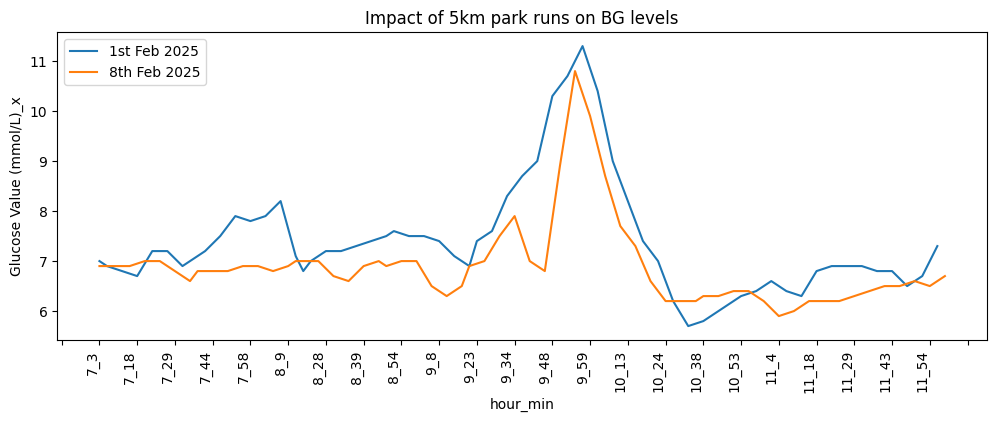

In [13]:
from matplotlib.ticker import MultipleLocator
plt.figure(figsize=(12,4))
ax = sns.lineplot(result['Glucose Value (mmol/L)_x'],label='1st Feb 2025')
ax = sns.lineplot(result['Glucose Value (mmol/L)_y'],label='8th Feb 2025')
ax.xaxis.get_major_locator()                    
ax.xaxis.get_major_formatter()        
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.title('Impact of 5km park runs on BG levels')
plt.legend(loc='upper left')
plt.xticks(rotation=90, ha='right');


Surprisingly, the 2 runs resulted in the HIGHEST BG readings over the entire sensor period! Interesting!

# 7. Conclusion <a class="anchor"  id="conclusion"></a>

In conclusion it has been a great learning experience, if anything I am very keen to keep my CV down! And I'm not done because I still have a lot more data to analyse, such as glucose vs satiety index and nutrient density, so look out for a part two. Just look at these juicy headers!:

In [14]:
diet.head(9)

,date,time,food,kcal,fat,carbs,protein,fat.1,carbs.1,protein.1,exercise,glucose_init,glucose_final,Nutrient Density (Per Calorie),satiety_index
0,31/01/2025,09:30,scrambled eggs,143.0,9.5,0.7,12.6,0.416667,0.030702,0.552631579,0.0,6.5,7.0,0.616,0.541
1,31/01/2025,09:30,spinach leaves,7.0,0.1,1.1,0.9,0.047619,0.523810,0.428571429,0.0,NaN,NaN,0.916,1.000
2,31/01/2025,09:30,salmon,140.0,7.9,0.0,16.1,0.329167,0.000000,0.670833333,0.0,NaN,NaN,0.705,0.792
3,31/01/2025,12:00,coffee,86.0,3.4,8.5,5.5,0.195402,0.488506,0.316091954,0.0,6.5,7.0,0.352,0.621
4,31/01/2025,12:40,pork steak,420.0,19.2,7.9,52.7,0.240602,0.098997,0.660401003,0.0,6.5,7.0,0.741,0.724
5,31/01/2025,12:40,cheese,89.0,7.0,0.7,5.7,0.522388,0.052239,0.425373134,0.0,NaN,NaN,0.079,0.517
6,31/01/2025,16:00,orange,83.0,0.4,20.8,1.3,0.017778,0.924444,0.057777778,0.0,6.5,7.4,0.395,0.666
7,31/01/2025,17:30,4 hash browns,576.0,36.0,60.0,5.6,0.354331,0.590551,0.05511811,0.0,6.0,7.8,0.318,0.403
8,31/01/2025,17:30,crumbed garlic mushrooms,150.0,7.7,16.0,5,0.268293,0.557491,0.174216028,0.0,NaN,NaN,0.784,0.922


In [15]:
diet['protein.1'] = np.where(diet['protein.1'] == '#VALUE!',0,diet['protein.1'])

In [16]:
foods_data = pd.read_csv('/kaggle/input/nutrient-density-satiety-and-glucose-data/net carbs vs glucose score vs satiety index_data_.csv')
foods_data.dtypes

Gs (%)                              float64
Protein %                           float64
Category                             object
Fii (%)                             float64
Food                                 object
Gi (%)                              float64
Nutrient Density (Per Serving)      float64
Popularity                           object
satiety index score                 float64
Serving Size (Cal)                  float64
Category.1                           object
Nutrient Density (Per Calorie)      float64
Protein %.1                         float64
Fat (%)                             float64
Fibre (%)                           float64
Gs (%).1                            float64
Net Carb (%)                        float64
Nutrient Density (Per Calorie).1    float64
Protein %.2                         float64
satiety index score.1               float64
satiety index score.2               float64
dtype: object

In [17]:
foods_data['protein_'] = foods_data['Protein %']/(foods_data['Protein %']+foods_data['Fat (%)']+foods_data['Net Carb (%)'])
foods_data['fat_'] = foods_data['Fat (%)']/(foods_data['Protein %']+foods_data['Fat (%)']+foods_data['Net Carb (%)'])
foods_data['carbs_'] = foods_data['Net Carb (%)']/(foods_data['Protein %']+foods_data['Fat (%)']+foods_data['Net Carb (%)'])
foods_data['satiety_index'] = foods_data['satiety index score']
foods_data.head(3)

,Gs (%),Protein %,Category,Fii (%),Food,Gi (%),Nutrient Density (Per Serving),Popularity,satiety index score,Serving Size (Cal),...,Gs (%).1,Net Carb (%),Nutrient Density (Per Calorie).1,Protein %.2,satiety index score.1,satiety index score.2,protein_,fat_,carbs_,satiety_index
0,0.329822,0.516628,plants,0.138060,Spinach,0.347710,0.389422,very popular,1.000000,26.535513,...,0.329822,0.236264,0.915710,0.516628,1.000000,1.000000,0.604438,0.119140,0.276422,1.000000
1,0.322535,0.520072,plants,0.204749,Bok Choy (Cooked),0.335469,0.251789,very popular,0.986954,17.797468,...,0.322535,0.256602,0.875153,0.520072,0.986954,0.986954,0.579862,0.134036,0.286102,0.986954
2,0.321290,0.836319,plants,0.425139,Watercress,0.296462,0.151709,very popular,0.983598,5.133919,...,0.321290,0.286695,0.874561,0.836319,0.983598,0.983598,0.693667,0.068540,0.237793,0.983598


In [18]:
from statsmodels.formula.api import ols

model_satiety = ols(formula = 'satiety_index ~ protein_+ fat_+ carbs_+ protein_:carbs_', data=foods_data).fit()
model_satiety.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          satiety_index   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     856.1
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          2.67e-161
Time:                        06:54:18   Log-Likelihood:                 403.63
No. Observations:                 356   AIC:                            -799.3
Df Residuals:                     352   BIC:                            -783.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3543      0.005     68.743      0.000       0.344       0.364
protein_            0.6924      0.013     53.694      0.000       0.667       0.718
fat_               -0.1578      0.012    -13.064      0.000      -0.182      -0.134
carbs_             -0.1803      0.011    -16.997      0.000      -0.201      -0.159
protein_:carbs_     0.9386      0.084     11.198      0.000       0.774       1.103
==============================================================================
Omnibus:                       48.806   Durbin-Watson:                   1.338
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.762
Skew:                          -0.827   Prob(JB):                     4.78e-18
Kurtosis:                       4.625   Cond. No.                     8.19e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.1e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [19]:
def weighted_average(df,data_col,weight_col,by_col):
    ''' Now data_col can be a list of variables '''
    df_data = df[data_col].multiply(df[weight_col], axis='index')
    df_weight = pd.notnull(df[data_col]).multiply(df[weight_col], axis='index')
    df_data[by_col] = df[by_col]
    df_weight[by_col] = df[by_col]    
    result = df_data.groupby(by_col).sum() / df_weight.groupby(by_col).sum()
    return result

In [20]:
diet = diet[diet["protein.1"].str.contains("#VALUE!") == False]
diet['fat.1']  = diet['fat.1'].astype(float)
diet['protein.1']  = diet['protein.1'].astype(float)
diet.dtypes

date                               object
time                               object
food                               object
kcal                              float64
fat                               float64
carbs                             float64
protein                            object
fat.1                             float64
carbs.1                           float64
protein.1                         float64
exercise                          float64
glucose_init                      float64
glucose_final                     float64
Nutrient Density (Per Calorie)    float64
satiety_index                     float64
dtype: object

In [21]:
weighted_average(diet,['fat.1','carbs.1','protein.1','Nutrient Density (Per Calorie)','satiety_index'],'kcal',['date','time'])

fat.1   carbs.1  protein.1  \
date       time                                   
01/02/2025 07:30  0.195402  0.488506   0.316092   
           11:20  0.335652  0.003478   0.660870   
           11:48  0.000000  0.967593   0.032407   
           13:12  0.685475  0.190961   0.123563   
           15:25  0.138849  0.547295   0.313856   
           17:00  0.710526  0.157895   0.131579   
           22:00  0.333333  0.583333   0.083333   
02/02/2025 06:45  0.685475  0.190961   0.123563   
           11:55  0.195402  0.488506   0.316092   
           13:15  0.435451  0.101009   0.463540   
           16:30  0.408429  0.351824   0.239747   
           17:45  0.052632  0.815789   0.131579   
03/02/2025 06:50  0.195402  0.488506   0.316092   
           08:35  0.142259  0.627615   0.230126   
           12:30  0.161955  0.608386   0.229659   
           16:00  0.000000  0.964467   0.035533   
           19:00  0.235890  0.386968   0.377143   
           20:45  0.333333  0.583333   0.083333   
04/02/2025 06:30  0.195402  0.488506   0.316092   
           09:15  0.195402  0.488506   0.316092   
           13:00  0.501766  0.152533   0.345701   
           15:00  0.110455  0.586003   0.303541   
           16:00  0.195402  0.488506   0.316092   
           18:30  0.245822  0.243217   0.510961   
           19:00  0.003774  0.988679   0.007547   
05/02/2025 07:10  0.195402  0.488506   0.316092   
           09:30  0.195402  0.488506   0.316092   
           12:30  0.535256  0.006164   0.458580   
           18:30  0.393430  0.497326   0.109244   
           18:45  0.003774  0.988679   0.007547   
           20:00  0.479887  0.125442   0.394670   
06/02/2025 07:00  0.685475  0.190961   0.123563   
           12:40  0.453267  0.041857   0.504876   
           14:00  0.195402  0.488506   0.316092   
           19:20  0.411814  0.068692   0.519494   
07/02/2025 07:00  0.195402  0.488506   0.316092   
           09:00  0.378196  0.127298   0.494505   
           10:00  0.685475  0.190961   0.123563   
           13:30  0.643991  0.006803   0.349206   
           15:25  0.276596  0.648936   0.074468   
           17:20  0.530658  0.209652   0.259690   
           19:20  0.246914  0.364198   0.388889   
08/02/2025 07:00  0.195402  0.488506   0.316092   
           11:30  0.453215  0.273733   0.273053   
           13:30  0.195402  0.488506   0.316092   
           17:50  0.126578  0.625726   0.247697   
09/02/2025 07:30  0.195402  0.488506   0.316092   
31/01/2025 09:30  0.365517  0.027783   0.606700   
           12:00  0.195402  0.488506   0.316092   
           12:40  0.289873  0.090822   0.619306   
           16:00  0.017778  0.924444   0.057778   
           17:30  0.336554  0.583721   0.079725   
           19:35  0.333333  0.583333   0.083333   

                  Nutrient Density (Per Calorie)  satiety_index  
date       time                                                  
01/02/2025 07:30                        0.352000       0.621000  
           11:20                        0.669000       0.576000  
           11:48                        0.325000       0.600000  
           13:12                        0.137600       0.610036  
           15:25                        0.395000       0.380000  
           17:00                        0.395000       0.197000  
           22:00                        0.000000       0.243000  
02/02/2025 06:45                        0.137600       0.610036  
           11:55                        0.352000       0.621000  
           13:15                        0.370284       0.632525  
           16:30                        0.454113       0.353037  
           17:45                        0.217000       0.473000  
03/02/2025 06:50                        0.352000       0.621000  
           08:35                        0.352000       0.621000  
           12:30                        0.015025       0.517483  
           16:00                        0.002000       0.417000  
           19:00           